In [2]:
%load_ext autoreload
%autoreload 1

from AirSeaFluxCode import AirSeaFluxCode
import xarray as xr
import gsw_xarray as gsw
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import gsw_xarray as gsw
import cartopy.crs as ccrs

%aimport my_funcs

my_funcs.update_params(fontsize=24)

In [3]:
def fix_xticks(ax):
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%B"))
    #ax.set_xlim(ds.time[0] - np.timedelta64(6,'H'),ds.time[-1] + np.timedelta64(6,'H'))
    ax.set_xlabel('2019')


In [4]:
c20 = "#C13F89"
c22 = "#3ec177"
c23 = "#3e88c1"
ext = "#a43ec1"

In [5]:
adcp20 = xr.open_dataset('../data/saildrone-gen_5-antarctica_circumnavigation_2019-sd1020-20190119T040000-20190803T043000-1_minutes-v1.1597092482498.nc')
ds20 = xr.open_dataset('../data/saildrone-gen_5-antarctica_circumnavigation_2019-sd1020-20190119T040000-20190803T043000-1_minutes-v1.1620360815446.nc')
ds20 = ds20.squeeze().swap_dims({'obs':'time'})

ds22 = xr.open_dataset('../data/Sd1022_data_merged.nc').set_coords(['longitude','latitude'])
ds23 = xr.open_dataset('../data/Sd1023_data_merged.nc').set_coords(['longitude','latitude'])

In [6]:
var = ['RH_MEAN','UWND_MEAN','VWND_MEAN','WWND_MEAN','BARO_PRES_MEAN','TEMP_CTD_RBR_MEAN','SAL_RBR_MEAN']
var = ['TEMP_AIR_MEAN','RH_MEAN','UWND_MEAN','BARO_PRES_MEAN','TEMP_CTD_RBR_MEAN','SAL_RBR_MEAN']
c = ['C0','C1','C2','C3','C4','C5']

## Calculate wind speed and air-sea fluxes

In [7]:
def calc_ws(ds):
    ds['wind_speed'] = np.sqrt(ds['UWND_MEAN']**2 + ds['VWND_MEAN']**2)
    return ds

In [8]:
ds20 = calc_ws(ds20)
ds22 = calc_ws(ds22)
ds23 = calc_ws(ds23)

In [9]:
def calc_tasf(ds):

        # Convert ship data into NumPy arrays
    lat  = np.asarray(ds["latitude"])               # Latitude
    spd  = np.asarray(ds["wind_speed"])               # Wind speed
    t    = np.asarray(ds["TEMP_AIR_MEAN"])               # Air temperature
    sst  = np.asarray(ds["TEMP_CTD_RBR_MEAN"])               # Sea surface temperature
    rh   = np.asarray(ds["RH_MEAN"])               # Relative humidity
    
    # Initialize a constant
    hin  = 17  # Height of the sensors (17 meters)
    
    # Calculate temperature at 2 meters above the sea surface ('t10n') and relative and specific humidity at 2 meters above the sea surface ('rh','q10n')
    
    air_hum = AirSeaFluxCode(spd, 
                                         t, 
                                         sst, 
                                         "skin", 
                                         meth = "C35", 
                                         lat = lat, 
                                         hin = [3.68,2.5,2.5], 
                                         hout = 2,
                                         hum=["rh", rh], 
                                         out_var = ["tref","rh", "qref",'qair','qsea'])
    
    # Calculate horizontal wind speed at 10 meters above the sea surface ('u10n')
    wind = AirSeaFluxCode(spd, 
                                         t, 
                                         sst, 
                                         "skin", 
                                         meth = "C35", 
                                         lat = lat, 
                                         hin = [3.68,2.5,2.5], 
                                         hout = 10,
                                         out_var = ["uref",'latent','sensible'])
    
    
    
    # Assign the calculated temperature values (converted to degrees Celsius) at 2 meters above the sea surface to the 't2m' column
    ds['t2m'] = ('time'), air_hum['tref'] - 273.15
    
    # Assign the calculated horizontal wind speed values at 10 meters above the sea surface to the 'u10' column
    ds['u10'] = ('time'), wind['uref']
    
    # Assign the calculated specific humidity values at 2 meters above the sea surface (converted to g/kg) to the 'qref' column
    ds['rh_corr'] = ('time'), air_hum['rh']
    ds['qref'] = ('time'), air_hum['qref']*1000
    ds['qair'] = ('time'), air_hum['qair']*1000
    ds['qsea'] = ('time'), air_hum['qsea']*1000
    
    # Assign some flags or indicators to the 'flags' column
    ds['flags'] = ('time'), wind['flag']
    
    # Assign some flags or indicators to the 'flags' column
    ds['sensible'] = ('time'), wind['sensible']
    ds['latent'] = ('time'), wind['latent']

    return ds

In [10]:
ds20 = calc_tasf(ds20)
ds22 = calc_tasf(ds22)
ds23 = calc_tasf(ds23)

## Plot data availability

Text(2019-02-01, 1.8, 'Data availability')

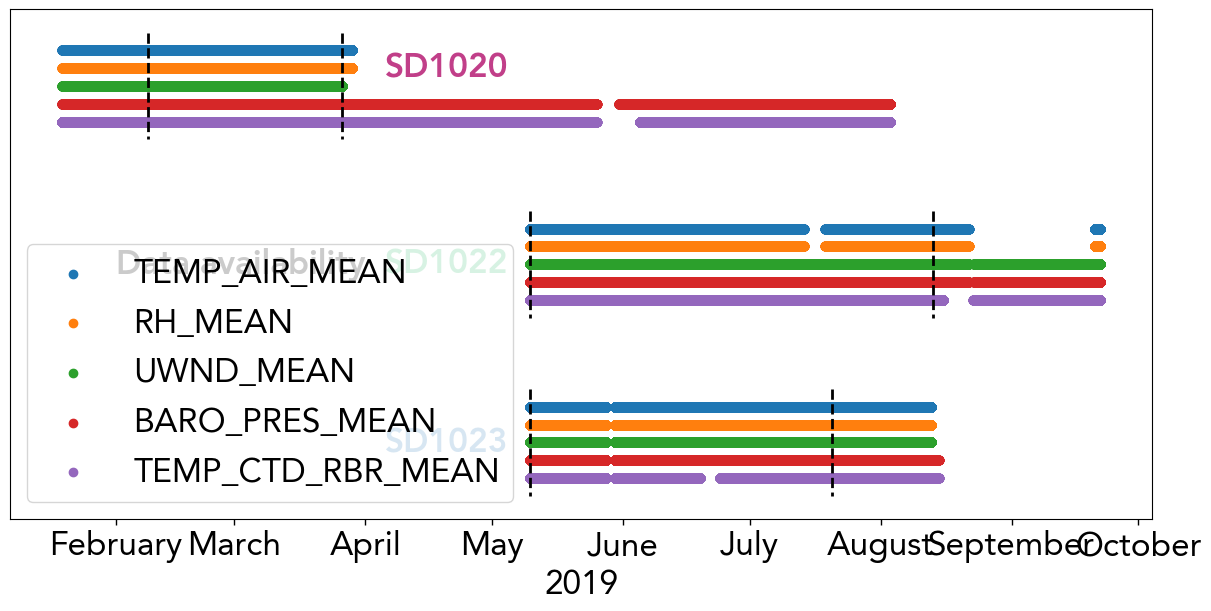

In [10]:
fig, ax = plt.subplots(figsize=(12,6),constrained_layout=True)

var = ['TEMP_AIR_MEAN','RH_MEAN','UWND_MEAN','BARO_PRES_MEAN','TEMP_CTD_RBR_MEAN']#,'SAL_RBR_MEAN']
c = ['C0','C1','C2','C3','C4','C5']

for ds,y,x1,x2 in zip([ds20,ds22,ds23],[3,2,1],[29510,0,0],[95630,137287,100000]):
    for d,(v,col) in enumerate(zip(var,c)):
        msk = np.where(np.isfinite(ds[v]))[0]
        if y == 3:
            ax.scatter(ds.time.values[msk],[y-0.1*d]*len(msk),c=col, label=v)
        else:
            ax.scatter(ds.time.values[msk],[y-0.1*d]*len(msk),c=col)
    
    ax.plot([ds.time[x1].values, ds.time[x1].values],[y+0.1,y-d*0.1-0.1],lw=2,ls='--',c='k')
    ax.plot([ds.time[x2].values, ds.time[x2].values],[y+0.1,y-d*0.1-0.1],lw=2,ls='--',c='k')

fix_xticks(ax)
ax.set_yticks([])
ax.legend(loc='lower left')

ax.text(np.datetime64("2019-04-20"),3-0.1, 'SD1020', fontweight='bold',c=c20, ha='center', va='center')
ax.text(np.datetime64("2019-04-20"),2-0.2, 'SD1022', fontweight='bold',c=c22, ha='center', va='center')
ax.text(np.datetime64("2019-04-20"),1-0.2, 'SD1023', fontweight='bold',c=c23, ha='center', va='center')

ax.text(np.datetime64("2019-02-01"),2-0.2, 'Data availability', fontweight='bold',c='k', ha='left', va='center')

#ax.text(np.datetime64("2019-02-01"),2-0.2, 'Data availability', fontweight='bold',c='k', ha='left', va='center')


[]

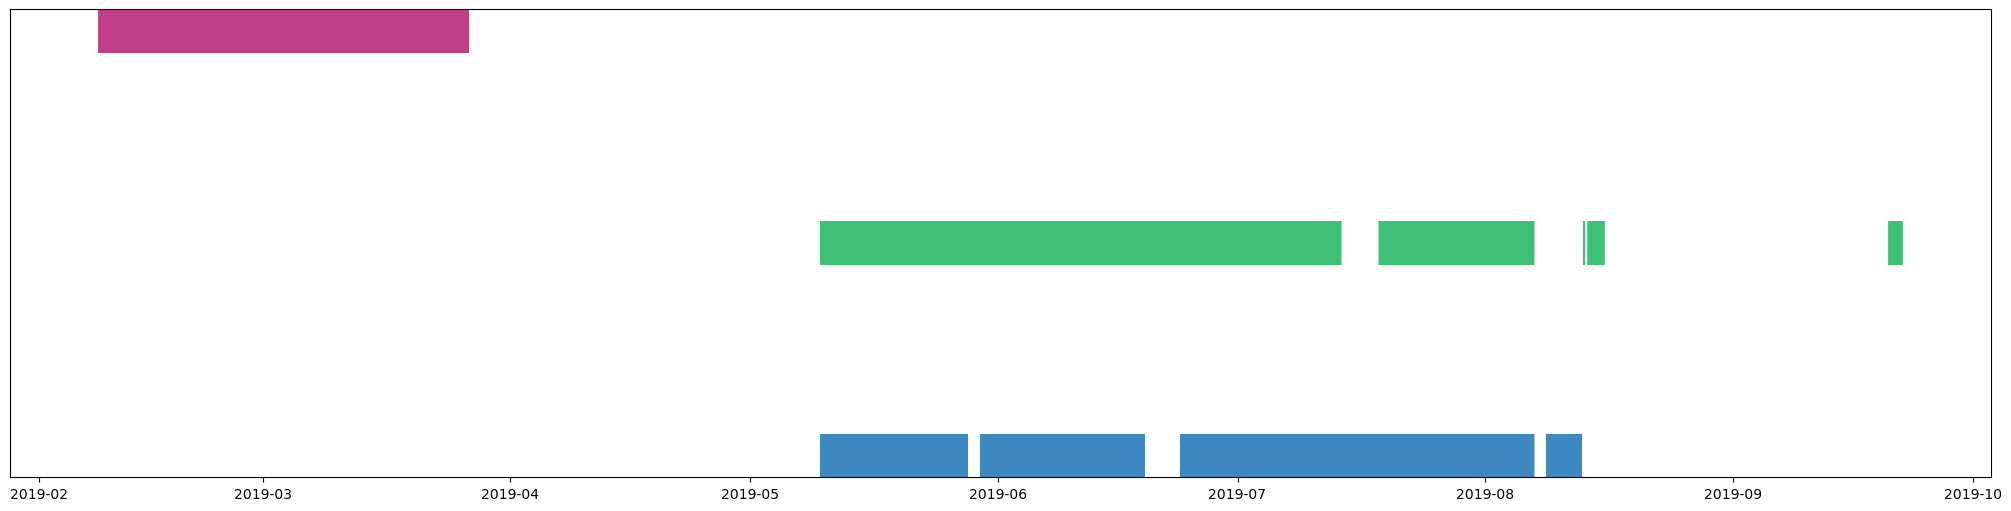

In [97]:
fig, ax = plt.subplots(figsize=(20,5),constrained_layout=True)
masks = []
dm = []
for ds,y,c in zip([ds20,ds22,ds23],[3,2,1],[c20,c22,c23]):
    #for d,(v,col) in enumerate(zip(var,c)):
    msk = np.where(np.logical_and(np.isfinite(ds[var[0]]),
                   np.logical_and(np.isfinite(ds[var[1]]),
                   np.logical_and(np.isfinite(ds[var[2]]),
                   np.logical_and(np.isfinite(ds[var[3]]),np.isfinite(ds[var[4]]))))))[0]
    masks.append(msk)
    dm.append(np.diff(msk))
    #dm = dm[dm<1000]
    ax.scatter(ds.time.values[msk],[y]*len(msk),c=c, s=1000,marker='|')
ax.set_yticks([])

In [95]:
def plot_sample_freq(ax,bx,ds,c,x1,x2,i,t,y=False,):
    
    ax.scatter(ds.time.values[masks[i]][1:],dm[i],marker='s',s=12,c=c)
    
    msk = np.where(np.logical_and(ds.time.values[masks[i]] > ds.time.values[x1],
                                  ds.time.values[masks[i]] < ds.time.values[x2]))[0]

    h = bx.hist(dm[i][msk],bins=np.arange(0,35,1),orientation='horizontal',align='left',fc=c,ec="None")
    bx.text(h[0][1],h[1][1]+2,(int(h[0][1])),ha='right', va='center',c='k',fontsize=8)
    bx.text(h[0][5],h[1][5]+2,(int(h[0][5])),ha='right', va='center',c='k',fontsize=8)
    if h[0][10] > 0:
        bx.text(h[0][10],h[1][10]+2,(int(h[0][10])),ha='right', va='center',c='k',fontsize=8)
    bx.set(xscale='log')
    bx.set_title(t,loc='right',y=0.85,x=0.95,fontweight='bold',va='center',c=c)
    ax.set(ylabel='Sampling frequency (minutes)' if y==True else '', ylim=(-1,35))
    
    ax.axvline(ds.time.values[x1],c='k',ls='--')
    ax.axvline(ds.time.values[x2],c='k',ls='--')
    

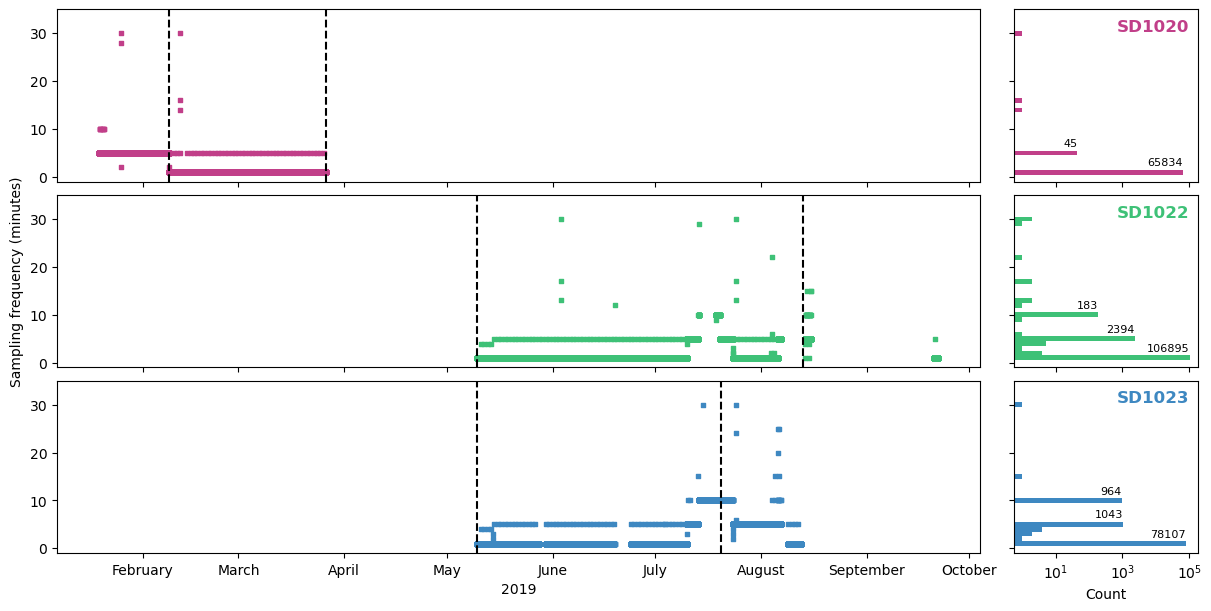

In [47]:
fig, ax = plt.subplots(3,2,figsize=(12,6),width_ratios=[5,1],sharey='row', sharex='col', constrained_layout=True)

plot_sample_freq(ax[0][0],ax[0][1],ds20,c20,29510,95630,0,'SD1020')
plot_sample_freq(ax[1][0],ax[1][1],ds22,c22,0,137287,1,'SD1022',y=True)
plot_sample_freq(ax[2][0],ax[2][1],ds23,c23,0,100000-1,2,'SD1023')

ax[2][1].set(xlabel="Count")
fix_xticks(ax[2][0])
plt.show()

In [12]:
for v in var:
    print(ds20[v].attrs['nominal_sampling_schedule'],':',v)

60s on, 240s off, centered at :00 : TEMP_AIR_MEAN
60s on, 240s off, centered at :00 : RH_MEAN
60s on, 240s off, centered at :00 : UWND_MEAN
60s on, 240s off, centered at :00 : BARO_PRES_MEAN
12s on, 48s off, centered at :00 : TEMP_CTD_RBR_MEAN


In [13]:
for v in var:
    print(ds22[v].attrs['nominal_sampling_schedule'],':',v)

60s on, 240s off, centered at :00 : TEMP_AIR_MEAN
60s on, 240s off, centered at :00 : RH_MEAN
60s on, 240s off, centered at :00 : UWND_MEAN
60s on, 240s off, centered at :00 : BARO_PRES_MEAN
12s on, 48s off, centered at :00 : TEMP_CTD_RBR_MEAN


In [14]:
for v in var:
    print(ds23[v].attrs['nominal_sampling_schedule'],':',v)

60s on, 240s off, centered at :00 : TEMP_AIR_MEAN
60s on, 240s off, centered at :00 : RH_MEAN
60s on, 240s off, centered at :00 : UWND_MEAN
60s on, 240s off, centered at :00 : BARO_PRES_MEAN
12s on, 48s off, centered at :00 : TEMP_CTD_RBR_MEAN


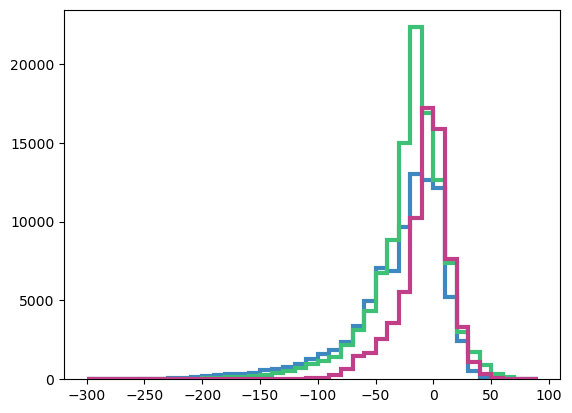

In [10]:
_=plt.hist(ds20['latent'] + ds20['sensible'],ec=c20,histtype='step',lw=3, bins=np.arange(-300,100,10),zorder=3)
_=plt.hist(ds22['latent'] + ds22['sensible'],ec=c22,histtype='step',lw=3, bins=np.arange(-300,100,10),zorder=2)
_=plt.hist(ds23['latent'] + ds23['sensible'],ec=c23,histtype='step',lw=3, bins=np.arange(-300,100,10),zorder=1)

#plt.yscale('log')

## Spatial distribution histograms

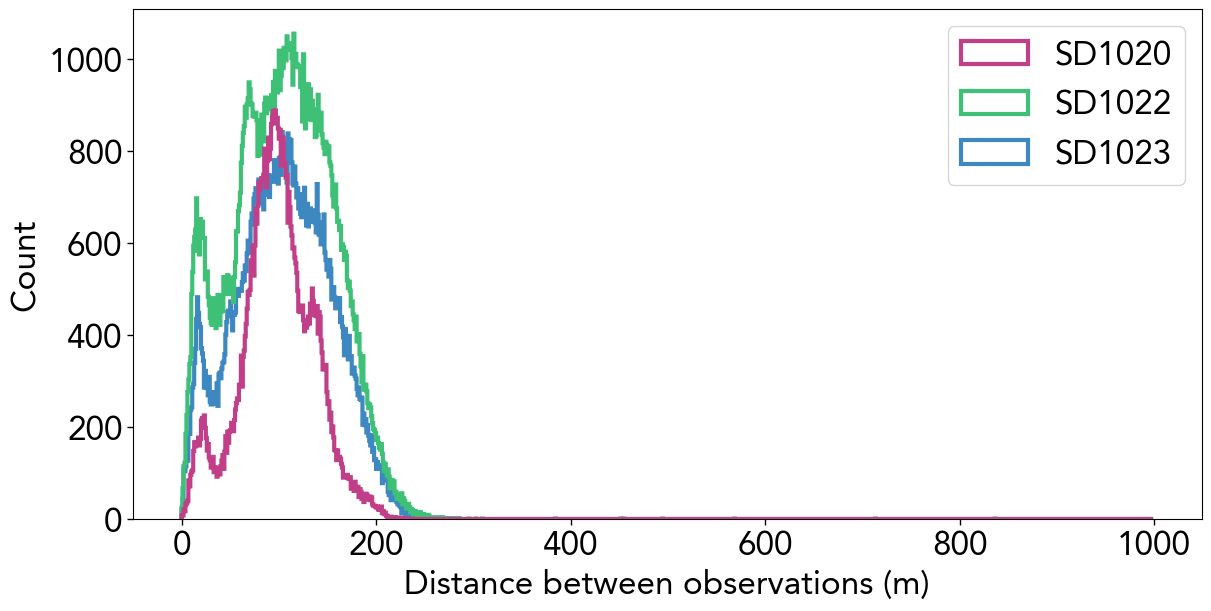

In [21]:
fig,ax = plt.subplots(figsize=(12,6),constrained_layout=True)

_=ax.hist(gsw.distance(ds20.longitude,ds20.latitude)[29510:95630],ec=c20,histtype='step',lw=3, bins=np.arange(0,1000,1),zorder=3, label='SD1020')
_=ax.hist(gsw.distance(ds22.longitude,ds22.latitude)[0:137287],ec=c22,histtype='step',lw=3, bins=np.arange(0,1000,1),zorder=2, label='SD1022')
_=ax.hist(gsw.distance(ds23.longitude,ds23.latitude)[0:100000],ec=c23,histtype='step',lw=3, bins=np.arange(0,1000,1),zorder=1, label='SD1023')

ax.set(ylabel='Count',xlabel='Distance between observations (m)')
ax.legend(loc='upper right')

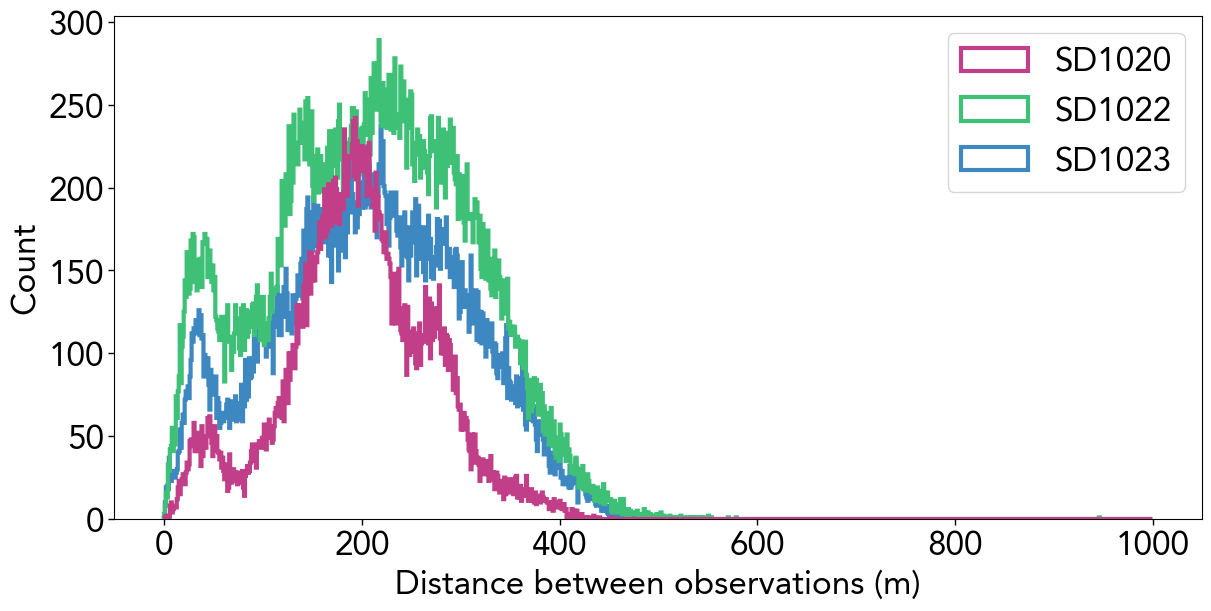

In [22]:
fig,ax = plt.subplots(figsize=(12,6),constrained_layout=True)

_=ax.hist(gsw.distance(ds20.longitude[::2],ds20.latitude[::2])[int(29510/2):int(95630/2)],ec=c20,histtype='step',lw=3, bins=np.arange(0,1000,1),zorder=3, label='SD1020')
_=ax.hist(gsw.distance(ds22.longitude[::2],ds22.latitude[::2])[0:int(137287/2)],ec=c22,histtype='step',lw=3, bins=np.arange(0,1000,1),zorder=2, label='SD1022')
_=ax.hist(gsw.distance(ds23.longitude[::2],ds23.latitude[::2])[0:int(100000/2)],ec=c23,histtype='step',lw=3, bins=np.arange(0,1000,1),zorder=1, label='SD1023')

ax.set(ylabel='Count',xlabel='Distance between observations (m)')
ax.legend(loc='upper right')

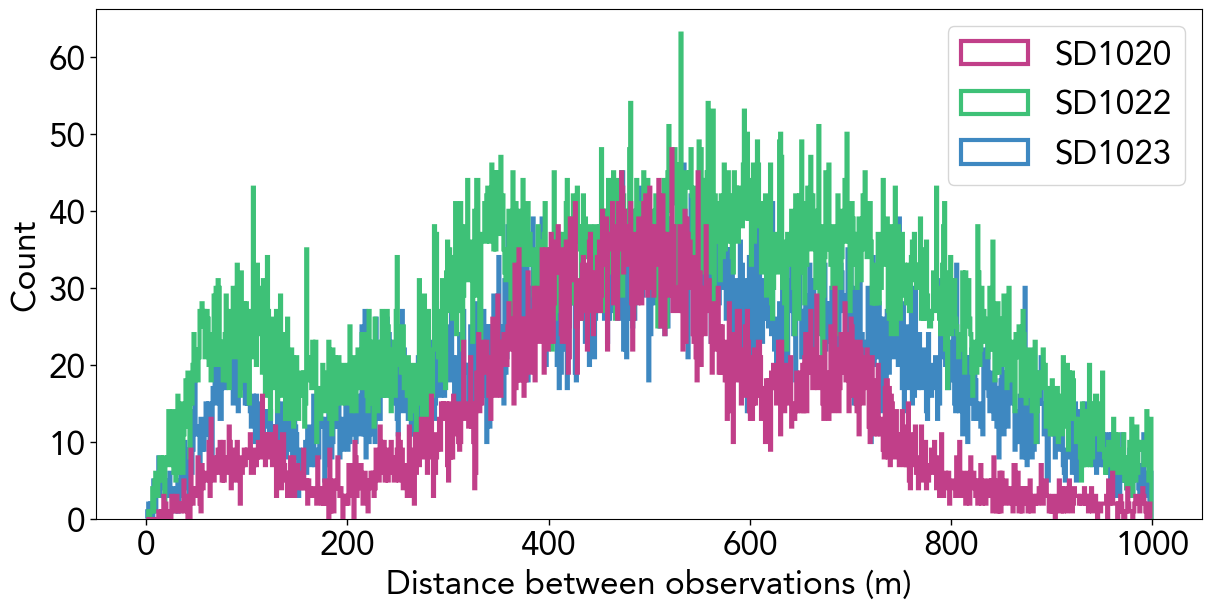

In [24]:
fig,ax = plt.subplots(figsize=(12,6),constrained_layout=True)

_=ax.hist(gsw.distance(ds20.longitude[::5],ds20.latitude[::5])[int(29510/5):int(95630/5)],ec=c20,histtype='step',lw=3, bins=np.arange(0,1000,1),zorder=3, label='SD1020')
_=ax.hist(gsw.distance(ds22.longitude[::5],ds22.latitude[::5])[0:int(137287/5)],ec=c22,histtype='step',lw=3, bins=np.arange(0,1000,1),zorder=2, label='SD1022')
_=ax.hist(gsw.distance(ds23.longitude[::5],ds23.latitude[::5])[0:int(100000/5)],ec=c23,histtype='step',lw=3, bins=np.arange(0,1000,1),zorder=1, label='SD1023')

ax.set(ylabel='Count',xlabel='Distance between observations (m)')
ax.legend(loc='upper right')

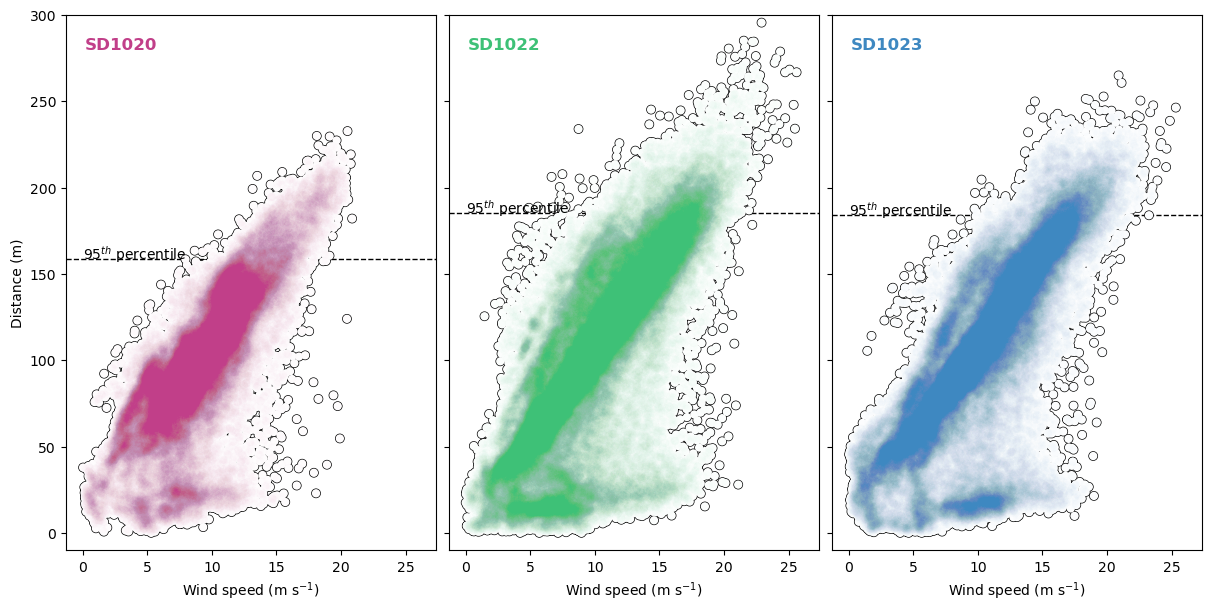

In [36]:
fig,ax = plt.subplots(1,3,figsize=(12,6),constrained_layout=True, sharex=True, sharey=True)

for axs,ds,x1,x2,c,t in zip(ax,[ds20,ds22,ds23],[29510,0,0],[95630,137287,100000],[c20,c22,c23],['SD1020','SD1022','SD1023']):
    axs.scatter(ds['wind_speed'][x1:x2],gsw.distance(ds.longitude,ds.latitude)[x1:x2],fc='None', ec='k',zorder=2)
    axs.scatter(ds['wind_speed'][x1:x2],gsw.distance(ds.longitude,ds.latitude)[x1:x2],fc='w', ec='None',zorder=3)
    axs.scatter(ds['wind_speed'][x1:x2],gsw.distance(ds.longitude,ds.latitude)[x1:x2],fc=c, ec='None',alpha=0.01,zorder=4)
    axs.set(ylim=(-10,300),xlabel="Wind speed (m s$^{-1}$)", ylabel="Distance (m)" if x1 != 0 else "")
    axs.set_title(t,loc='left',x=0.05,y=0.92,fontweight='bold',c=c)
    axs.axhline(np.nanpercentile(gsw.distance(ds.longitude,ds.latitude)[x1:x2],95),c='k',ls='--',lw=1,zorder=1)
    axs.text(-0.5,np.nanpercentile(gsw.distance(ds.longitude,ds.latitude)[x1:x2],95),'95$^{th}$ percentile')

In [11]:
def calc_dens(ds):
    ds['SA'] = gsw.SA_from_SP(ds['SAL_RBR_MEAN'],0,ds['longitude'],ds['latitude'])
    ds['CT'] = gsw.CT_from_t(ds['SA'],ds['TEMP_CTD_RBR_MEAN'],0)
    ds['rho'] = gsw.rho(ds['SA'],ds['CT'],0)
    return ds

In [12]:
ds20 = calc_dens(ds20)
ds22 = calc_dens(ds22)
ds23 = calc_dens(ds23)

## Temporal autocorrelation

In [ ]:
# ds20 = ds20.resample(time='1min').mean('time')

In [11]:
import statsmodels.api as sm

In [32]:
def calc_and_plot_acv(ax,var):
    
    x = ds20[var].isel(time=slice(29510,95630)).interpolate_na('time').values
    msk = np.isfinite(x)
    x = x[msk]
    acf = []
    #calculate autocorrelations
    for i in range(int(len(x)/60)):
        ac = sm.tsa.acf(x[60*i : 60*(i+1)+1],nlags=60,missing='conservative')
        ax.plot(ac,c='k',alpha=0.05,zorder=2)
        acf.append(ac)
    return acf

In [13]:
ds20['sal'] = ds20['SAL_RBR_MEAN'].copy()#.rolling(time=5,center=True).median('time')

In [14]:
ds20['sal'] = ds20['sal'].where(ds20['sal'] > 33.5)

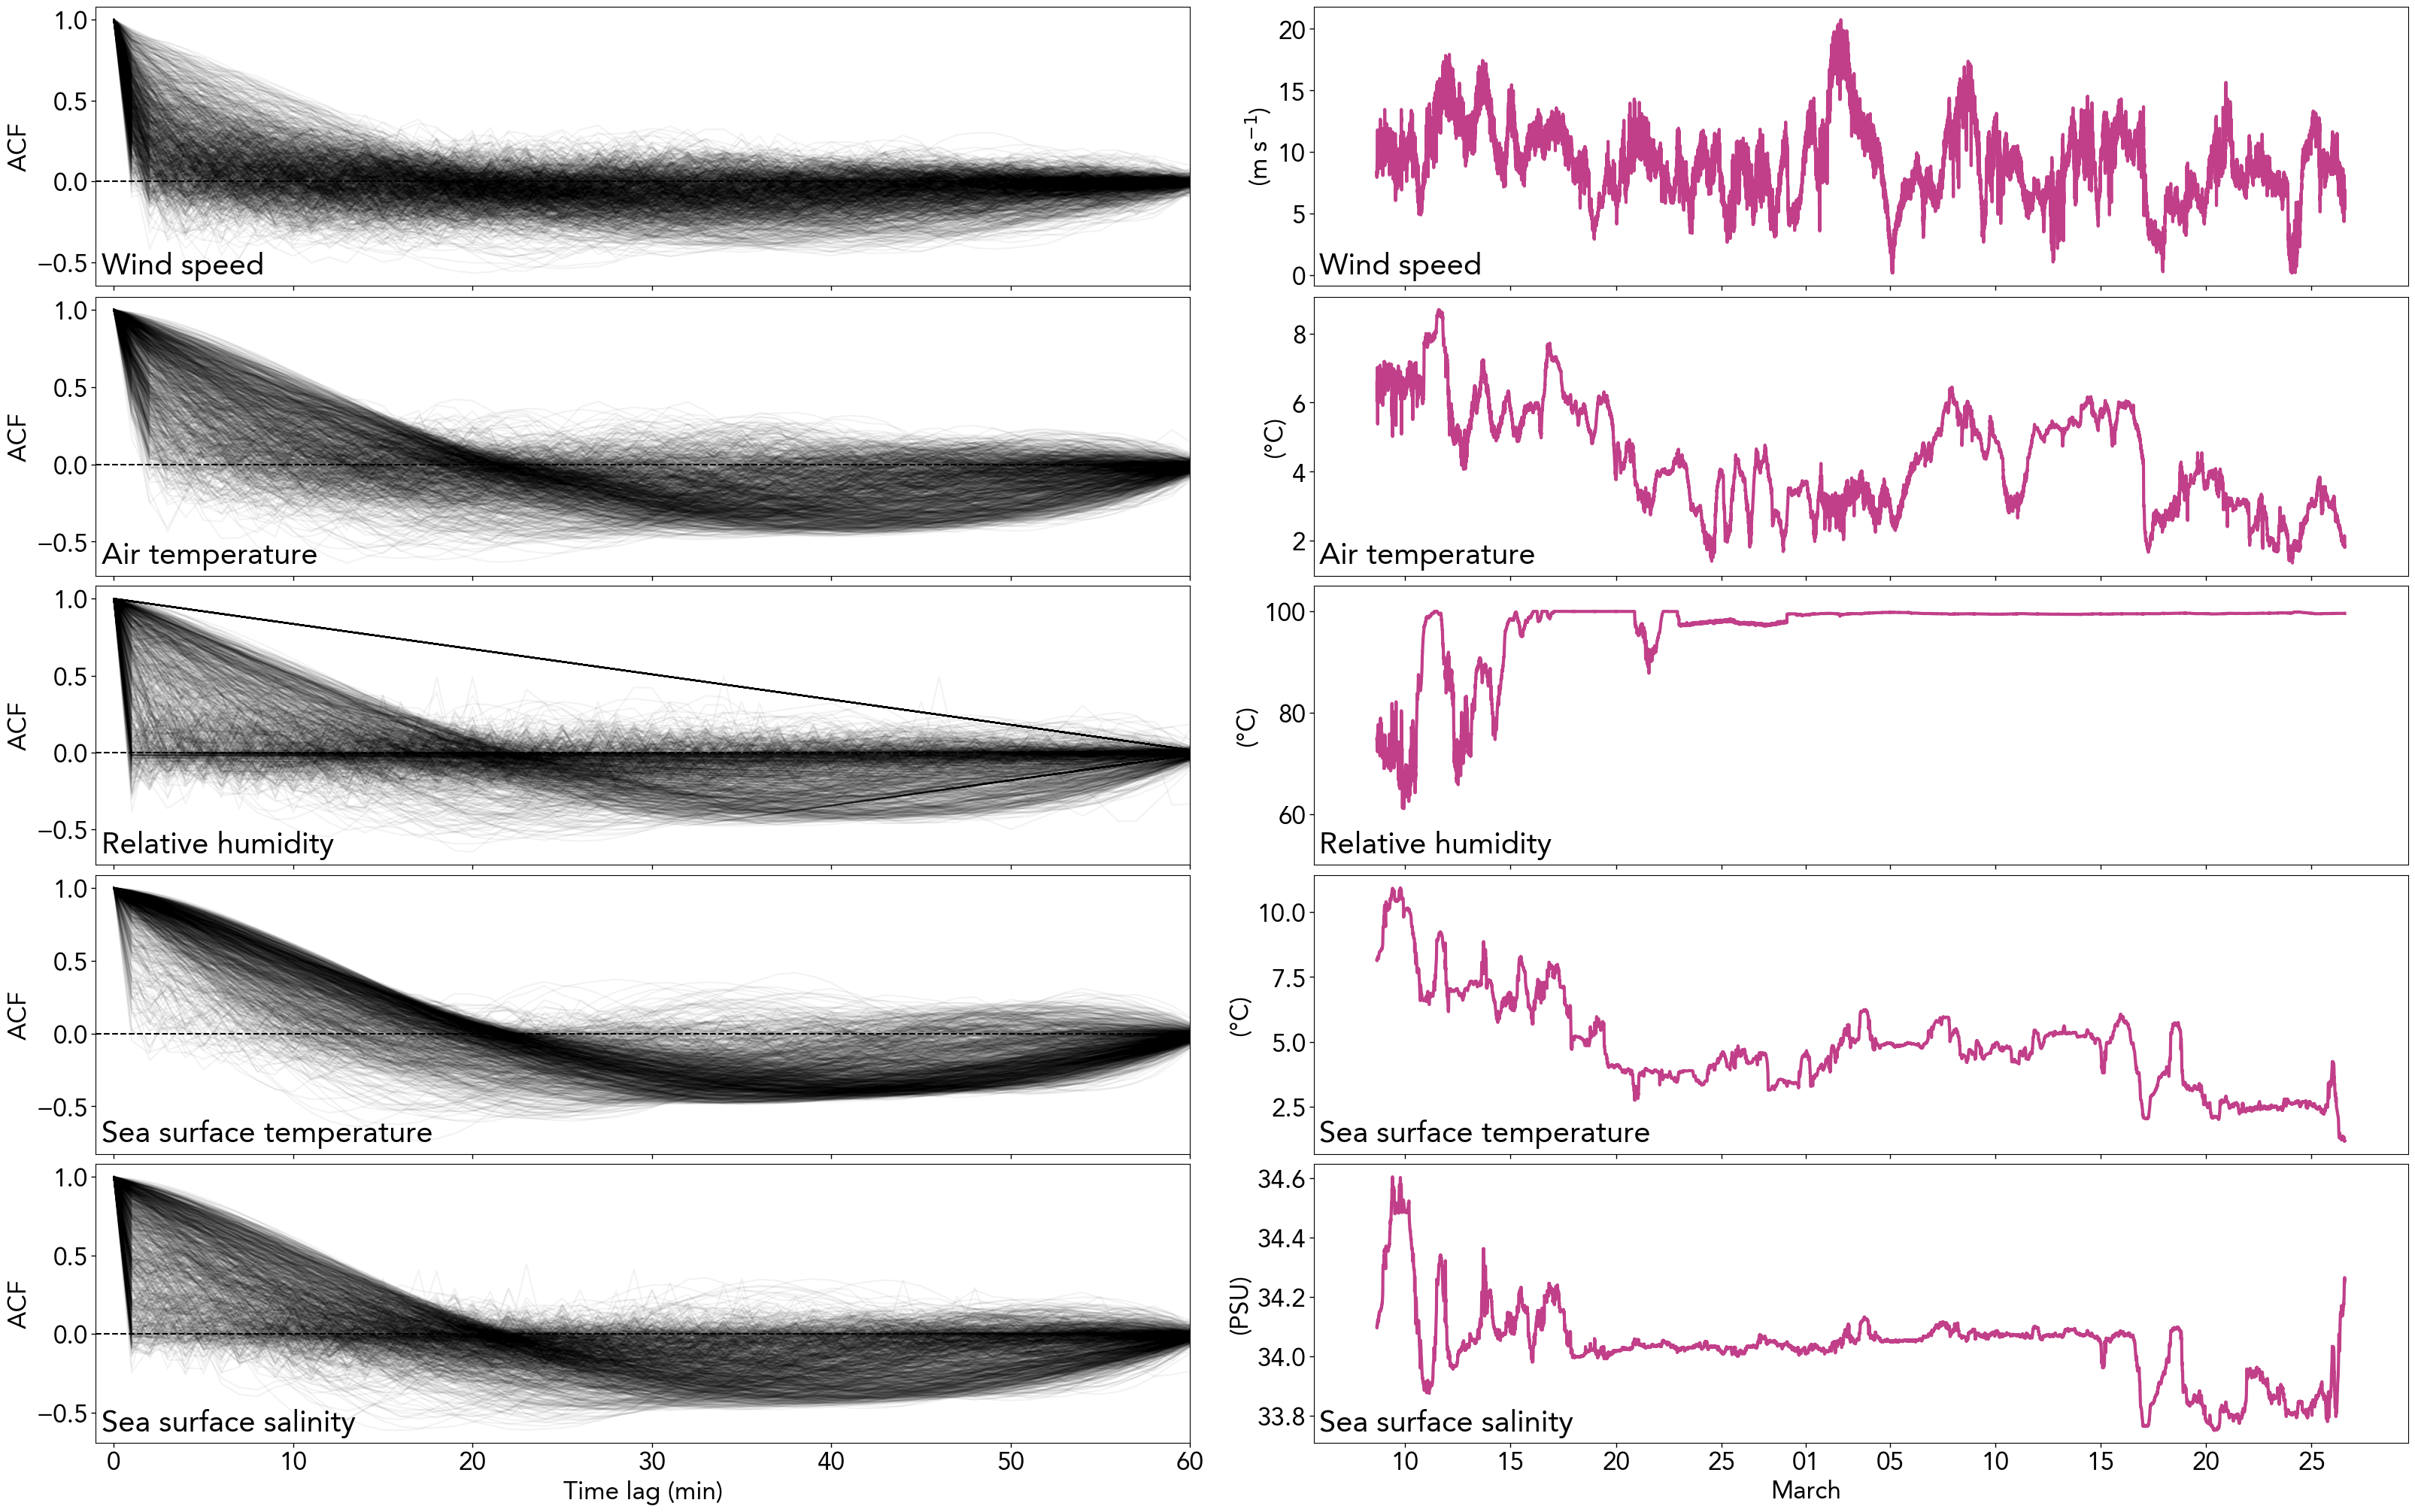

In [20]:
vars = ['wind_speed','TEMP_AIR_MEAN','RH_MEAN','TEMP_CTD_RBR_MEAN','SAL_RBR_MEAN']
titles = ['Wind speed','Air temperature','Relative humidity','Sea surface temperature','Sea surface salinity']

fig,ax = plt.subplots(int(len(vars)),2,constrained_layout=True,figsize=(32,4*len(vars)),sharex='col')

acf = []

for axs,var,t in zip(ax.T[0],vars,titles):
    acf.append(calc_and_plot_acv(axs,var))
    axs.set(xlabel='Time lag (min)' if "SAL" in var else "",xlim=(-1,60),ylabel="ACF")
    axs.set_title(t,loc='left',x=0.005,y=0.02)
    axs.axhline(0,ls='--',zorder=1,c='k')

vars = ['wind_speed','TEMP_AIR_MEAN','RH_MEAN','TEMP_CTD_RBR_MEAN','sal']
units = ["m s$^{-1}$", "°C", "°C", "°C", "PSU"]

for axs,var,t,u in zip(ax.T[1],vars,titles,units):
    ds20[var].isel(time=slice(29510,95630)).rolling(time=3,center=True).median('time').plot(ax=axs,c=c20,lw=3)    
    axs.set(ylabel=f"({u})",title='',xlabel="")
    axs.set_title(t,loc='left',x=0.005,y=0.02)

ax.T[1][2].set(ylim=(50,105))

my_funcs.fix_xticks([axs],ds20.isel(time=slice(29510,95630)))

In [29]:
ds20

<xarray.Dataset>
Dimensions:                         (time: 282271)
Coordinates:
    latitude                        (time) float64 -46.68 -46.68 ... -46.6 -46.6
    longitude                       (time) float64 168.5 168.5 ... 168.4 168.4
  * time                            (time) datetime64[ns] 2019-01-19T04:00:00...
    trajectory                      float32 1.02e+03
Data variables: (12/60)
    SOG                             (time) float64 ...
    COG                             (time) float64 ...
    HDG                             (time) float64 ...
    HDG_WING                        (time) float64 ...
    WING_ANGLE                      (time) float64 ...
    UWND_MEAN                       (time) float64 13.7 nan nan ... nan nan nan
    ...                              ...
    qair                            (time) float64 10.08 nan nan ... nan nan nan
    qsea                            (time) float64 10.83 10.83 ... 7.386 7.382
    flags                           (time) object 'n' 'm' 'm' ... 'm' 'm' 'm'
    sensible                        (time) float64 6.003 nan nan ... nan nan nan
    latent                          (time) float64 1.768e-319 ... 1.768e-319
    sal                             (time) float64 34.66 34.68 34.67 ... nan nan
Attributes: (12/38)
    title:                     Antarctica Circumnavigation Surface Data
    summary:                   This data set was collected from the first Sai...
    ncei_template_version:     NCEI_NetCDF_Trajectory_Template_v2.0
    Conventions:               CF-1.6, ACDD-1.3
    netcdf_version:            4.6.3
    featureType:               trajectory
    ...                        ...
    geospatial_lat_min:        -60.9862208
    geospatial_lat_max:        -46.4277568
    geospatial_lat_units:      degrees_north
    geospatial_lon_min:        -179.9986816
    geospatial_lon_max:        179.9997312
    geospatial_lon_units:      degrees_east

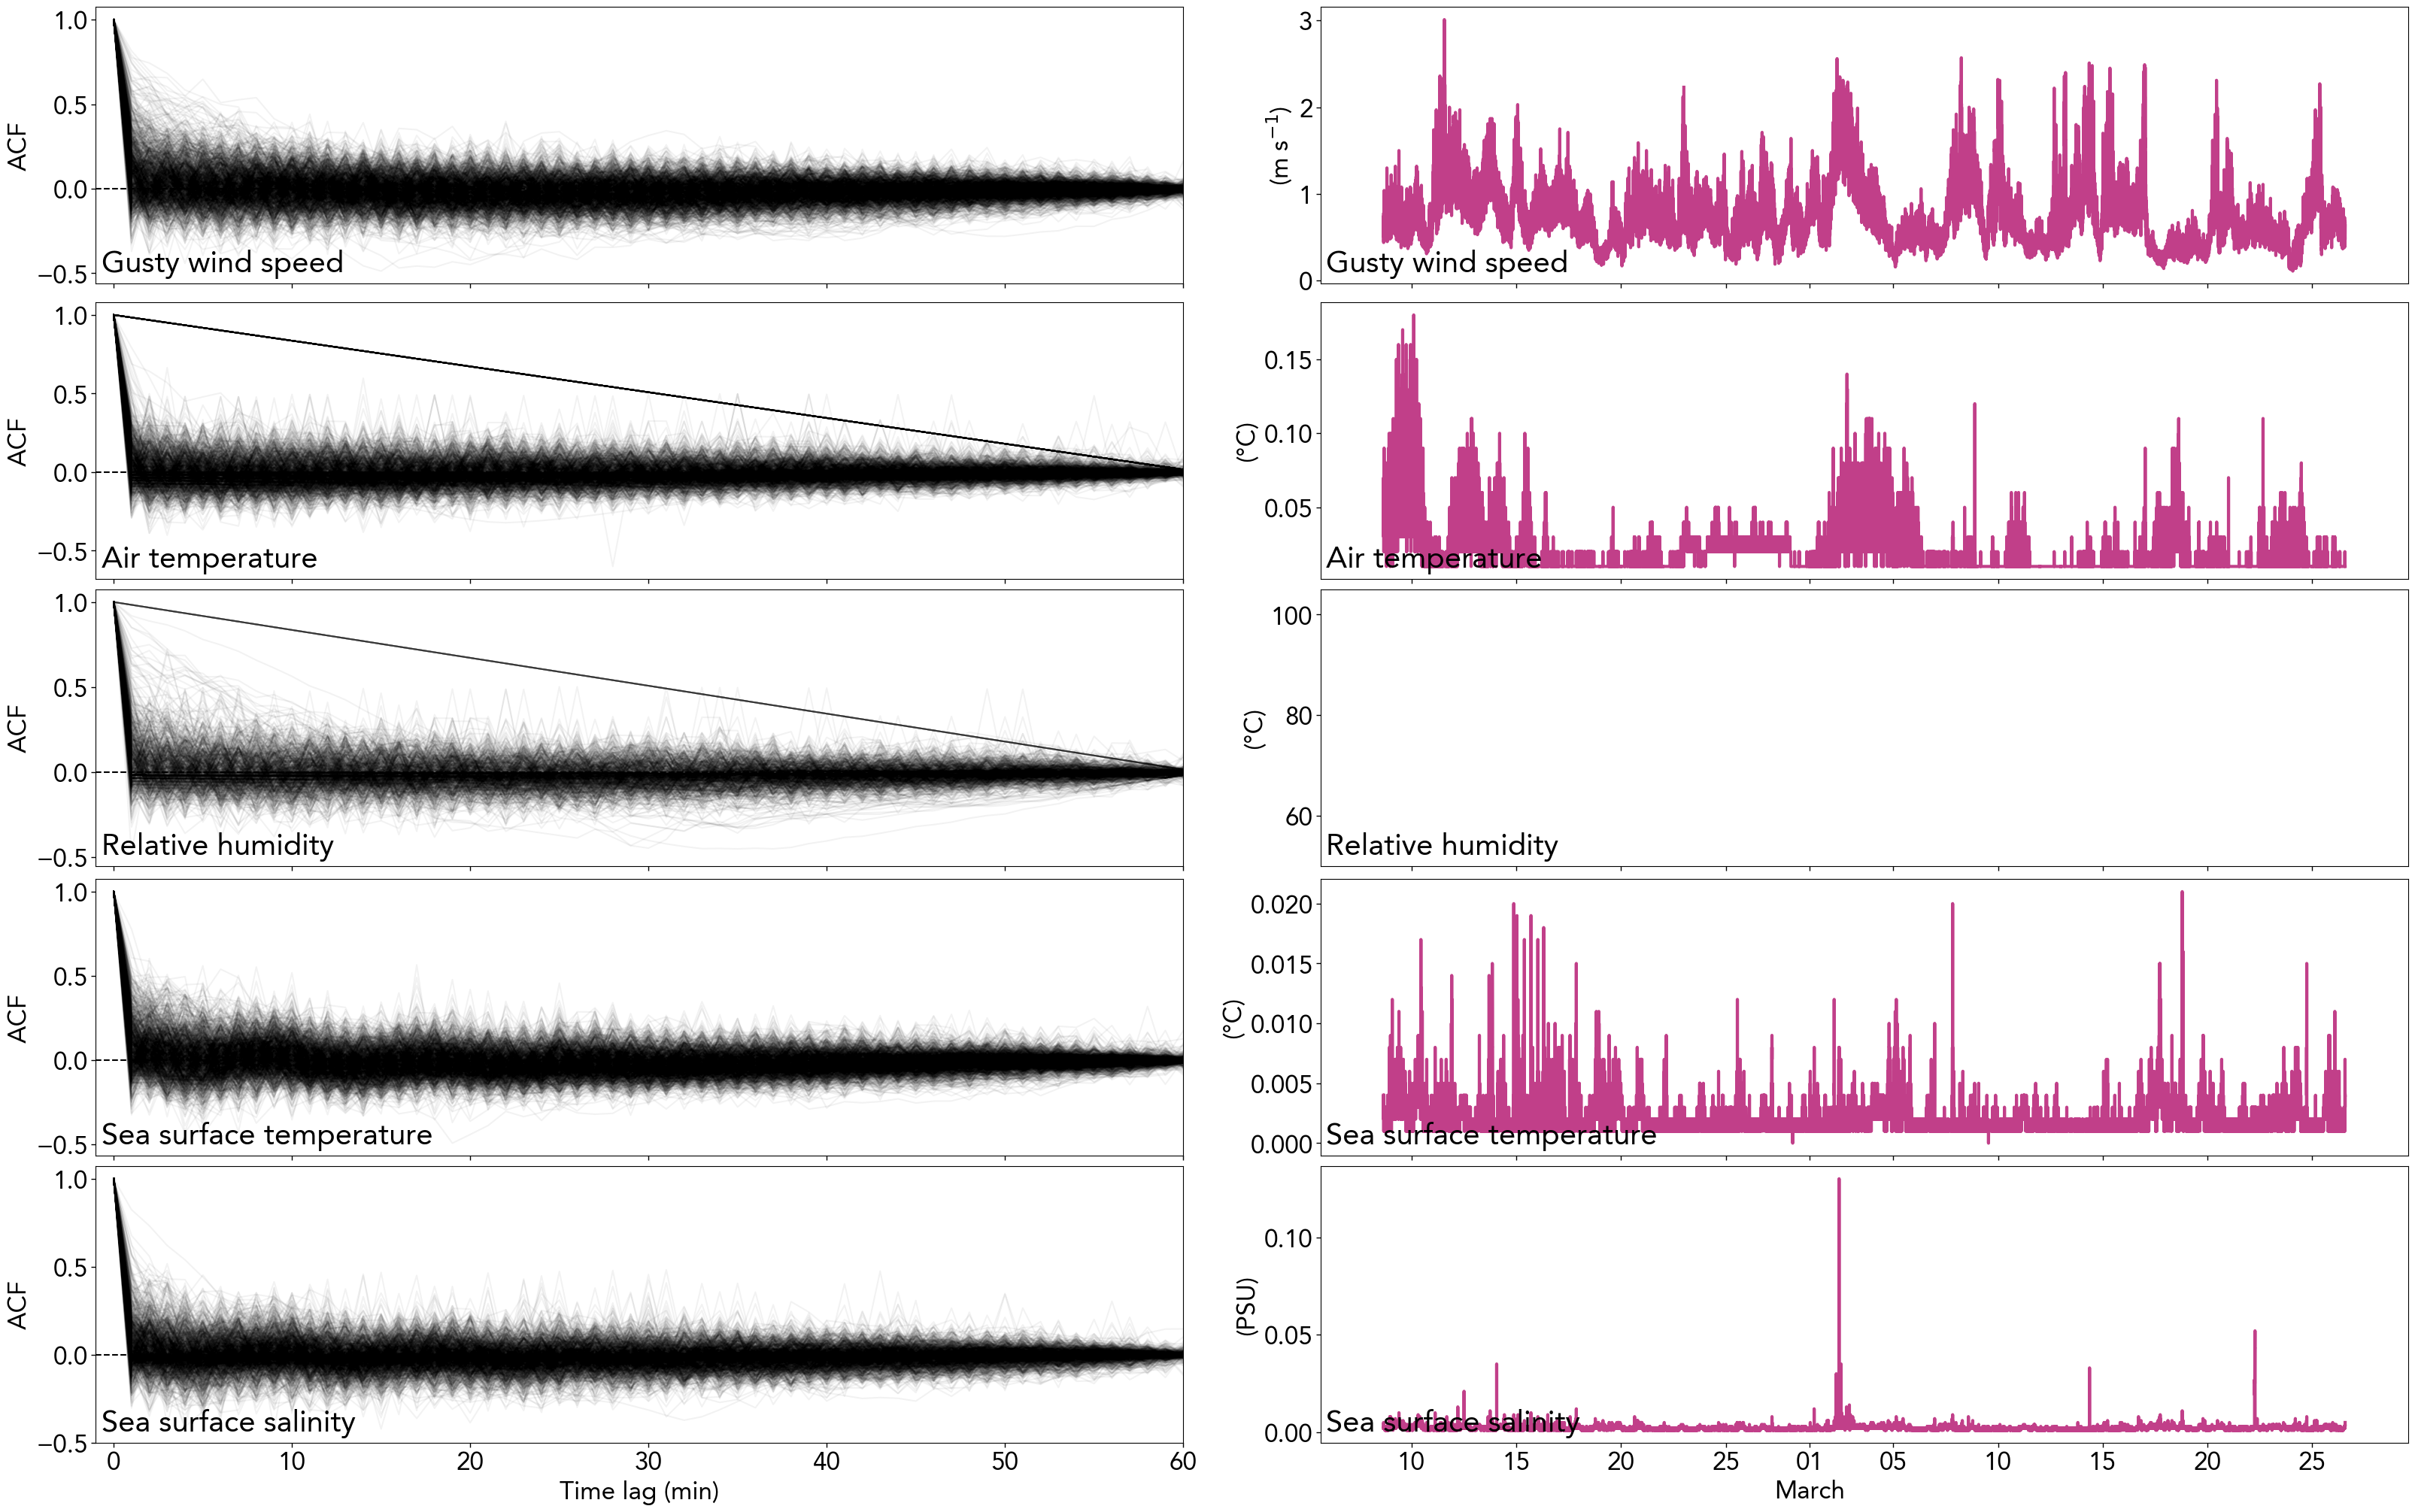

In [33]:
vars = ['GUST_WND_STDDEV','TEMP_AIR_STDDEV','RH_STDDEV','TEMP_CTD_RBR_STDDEV','SAL_RBR_STDDEV']
titles = ['Gusty wind speed','Air temperature','Relative humidity','Sea surface temperature','Sea surface salinity']

fig,ax = plt.subplots(int(len(vars)),2,constrained_layout=True,figsize=(32,4*len(vars)),sharex='col')

acf = []

for axs,var,t in zip(ax.T[0],vars,titles):
    acf.append(calc_and_plot_acv(axs,var))
    axs.set(xlabel='Time lag (min)' if "SAL" in var else "",xlim=(-1,60),ylabel="ACF")
    axs.set_title(t,loc='left',x=0.005,y=0.02)
    axs.axhline(0,ls='--',zorder=1,c='k')

#vars = ['wind_speed','TEMP_AIR_MEAN','RH_MEAN','TEMP_CTD_RBR_MEAN','sal']
units = ["m s$^{-1}$", "°C", "°C", "°C", "PSU"]

for axs,var,t,u in zip(ax.T[1],vars,titles,units):
    ds20[var].isel(time=slice(29510,95630)).rolling(time=3,center=True).median('time').plot(ax=axs,c=c20,lw=3)    
    axs.set(ylabel=f"({u})",title='',xlabel="")
    axs.set_title(t,loc='left',x=0.005,y=0.02)

ax.T[1][2].set(ylim=(50,105))

my_funcs.fix_xticks([axs],ds20.isel(time=slice(29510,95630)))